# Run BADASS for NucB (GGS)

#### Installs and imports

In [66]:
!pip install fair-esm

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: flatbuffers 1.12.1-git20200711.33e2d80-dfsg1-0.6 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of flatbuffers or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [67]:
# Load packages and define ref_seq for Mut321
%run setup_environment.py
import seq2fitness_models as models
import protein_optimizer
import seq2fitness_traintools as traintools
import seq2fitness_train as train
#import evo_prot_grad
#import seq2fitness_expert
#import evo_prot_grad.common.sampler as sampler
import os
import pickle
import time
import gc
import joblib
from pprint import pprint
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seq2fitness_protein_optimizer as protein_optimizer
importlib.reload(protein_optimizer)

from typing import List
from sequence_utils import rel_sequences_to_dict, convert_rel_seqs_to_tensors, pad_rel_seq_tensors_with_nan
from sequence_utils import apply_mutations, pseudolikelihood_ratio_from_tensor, generate_single_mutants
from seq2fitness_models import compute_model_scores

Paths added to sys.path:
/home/ubuntu/DEML-Virginia/NucB-training/DEML/src/data
/home/ubuntu/DEML-Virginia/NucB-training/DEML/src/representation
/home/ubuntu/DEML-Virginia/NucB-training/DEML/src/representation/prep
/home/ubuntu/DEML-Virginia/NucB-training/DEML/src/utils
/home/ubuntu/DEML-Virginia/NucB-training/DEML/src/end_to_end_models
/home/ubuntu/DEML-Virginia/NucB-training/DEML/src/training
/home/ubuntu/DEML-Virginia/NucB-training/DEML/src/mld
/home/ubuntu/DEML-Virginia/NucB-training/DEML/src/mld/libdesign
/home/ubuntu/DEML-Virginia/NucB-training/DEML/src/inference
/home/ubuntu/DEML-Virginia/NucB-training/DEML/src/models
/home/ubuntu/DEML-Virginia/NucB-training/DEML/EvoProtGrad/evo_prot_grad
/home/ubuntu/DEML-Virginia/NucB-training/DEML/EvoProtGrad/evo_prot_grad/experts


## Now Optimize ML Model Scores

#### K=6

In [ ]:
NUM_MUT = 6
NUM_ITER = 200
THRESHOLD = 10

model_path = '../NucB/trained_models/nucb_GGS_model_final_model_epoch_43_val_loss_0.8608.pt'

new_task_weights = {
    'activity_greater_than_neg_control': 0.000,
    'activity_greater_than_wt': 1.000,
    'activity_greater_than_a73r': 0.000
}

optimizer_params = {
    'new_task_weights': new_task_weights,
    'normalize_scores': True,
    'score_threshold': THRESHOLD, 
    'reversal_threshold': 0.0,
    #'ref_score_value': 0.0, 
    #'ref_score_scale': 0.0, 
    'seqs_per_iter': 520, 
    'num_iter':NUM_ITER, 
    'init_score_batch_size': 500, # only useful if score matrix is not specified, to compute single mutant scores
    'T': 1.5, # use 3 for not normalized scores
    'seed': 7,
    'gamma': 1.0, # typically 1.0
    'cooling_rate': 0.9 , # for slower simple cooling. Use 0.9 for a fast one
    'num_mutations': NUM_MUT,
    'sites_to_ignore': [1] # known bad sites that we should not sample sequences from
}

'''
# Load from the pickle file
with open('single_mutant_scores_amylase.pkl', 'rb') as file:
   initial_score_matrix = pickle.load(file)
'''

import seq2fitness_protein_optimizer as protein_optimizer
importlib.reload(protein_optimizer)
optimizer = protein_optimizer.ProteinOptimizer(optimizer_params, 
                                               model_checkpoint_path=model_path, 
                                               model_params=None, 
                                               esm_only=False,
                                               score_matrix=None,
                                               simple_simulated_annealing=False, 
                                               cool_then_heat = False)
initial_score_matrix = optimizer.initial_score_matrix
print(f"phase transition threshold is {optimizer.score_threshold}")




# Run optimizer
start_time = time.time()
df, df_stats = optimizer.optimize()
end_time = time.time()
# Print the elapsed time

Our main device will be cuda:0
Total number of trainable parameters in the model: 125487
Number of trainable parameters in the model excluding ESM: 125487
Total number of parameters in the model: 651168741
The reference sequence is MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASRYPETGAHISDAIKAGHADVCTIERSGADKRRQESLKGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGAGSWVGNRLNGYADGTRILFIVQ.
Our main device is still cuda:0
The reference sequence has score -6.57.
Computing initial score matrix, using batches of 500.
Scoring all single mutants to compute initial score matrix.
Computing scores for 2679 single mutants.
Finished sequence 0 of 2679.
Finished sequence 500 of 2679.
Finished sequence 1000 of 2679.
Finished sequence 1500 of 2679.
Finished sequence 2000 of 2679.
Finished sequence 2500 of 2679.
Reference score value: -7.9975, std dev: 7.4738. To normalize scores.
phase transition threshold is 10

Starting iter 0: processing 520 sequences, using T = 1.5.
Joint probability has 1.95e+03 effective entri

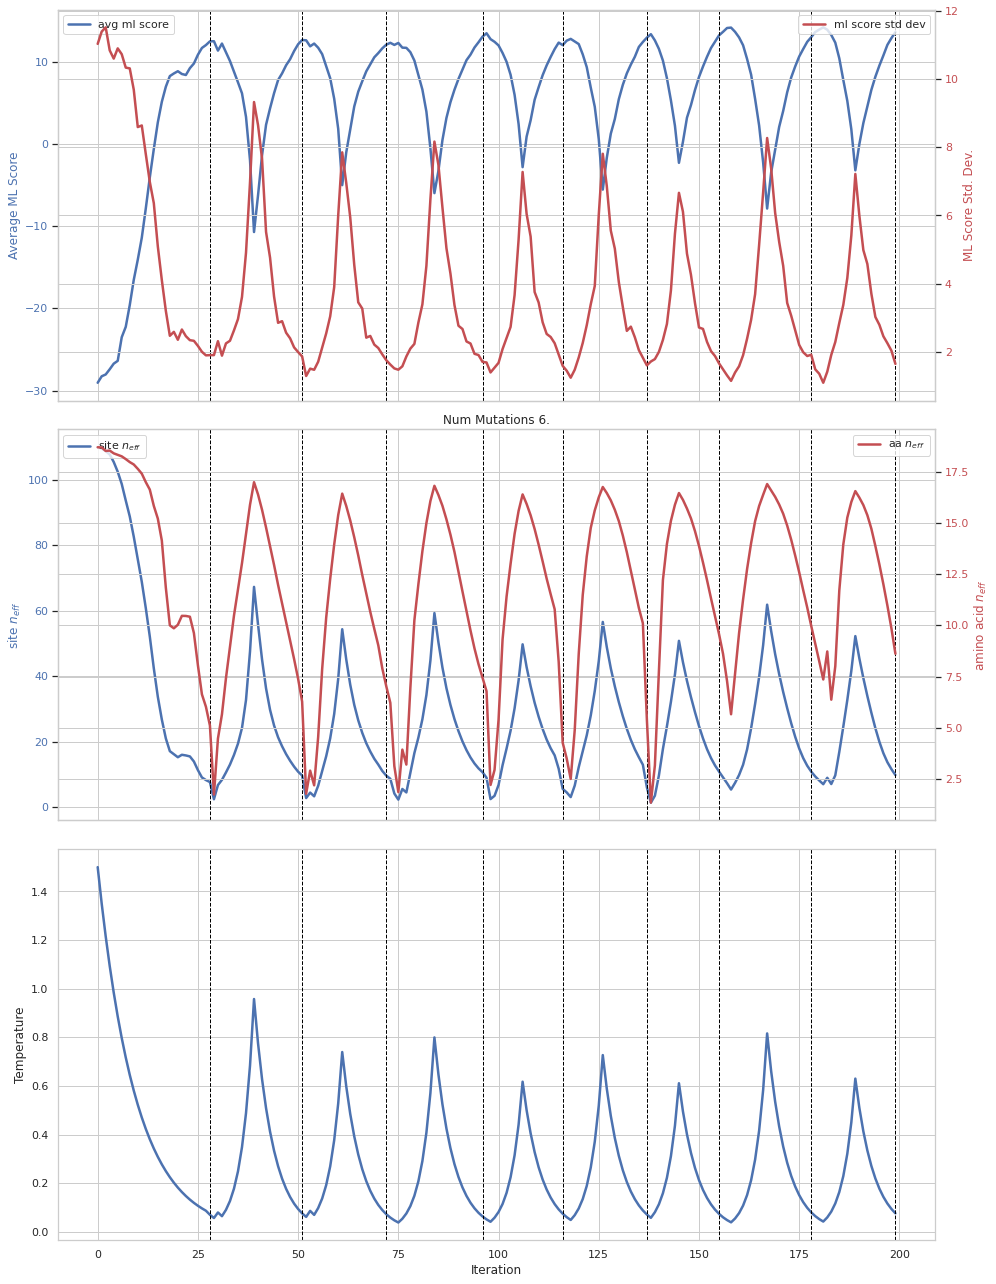

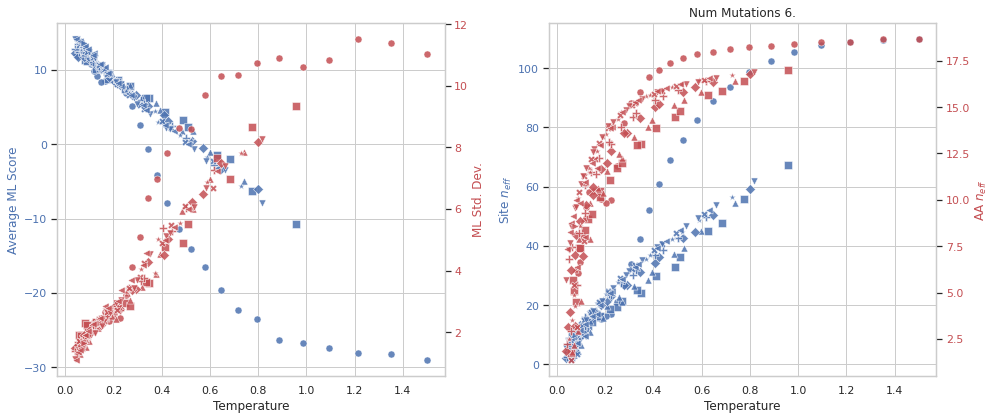

27
27


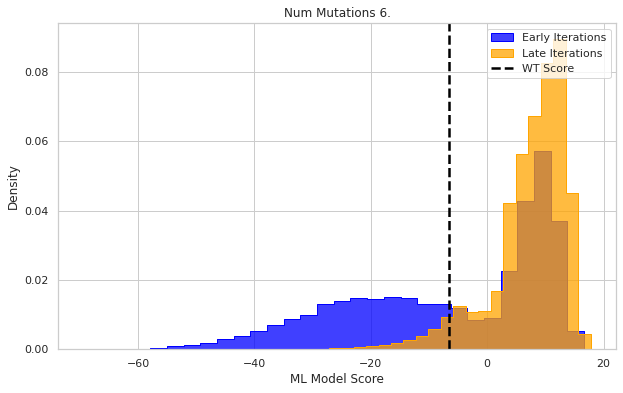

In [72]:
optimizer.plot_scores()

In [75]:

def score_sequences(sequences, n_batch=2000):
    
    old_modelpath = '../NucB/trained_models/nucb_model_final_model_epoch_100_val_loss_0.5445.pt'
    model, model_params, _ = traintools.ModelCheckpoint.load_model(old_modelpath)
    model = model.eval()
    device = model.device
    tokenizer = model.alphabet.get_batch_converter() # Esm tokenizer since fwd method expects tokens

    def prepare_batch(inputs, device):
        rel_seqs_dict = rel_sequences_to_dict(inputs, sep='-') 
        rel_seqs_list_of_dicts = [rel_seqs_dict[key] for key in sorted(rel_seqs_dict)] 
        abs_seqs = [apply_mutations(ref_seq_nucb, rel_seq) for rel_seq in rel_seqs_list_of_dicts]
        batch_labels, batch_strs, batch_tokens = tokenizer([(str(i), seq) for i, seq in enumerate(abs_seqs)])
        rel_seqs_tensors = convert_rel_seqs_to_tensors(rel_seqs_list_of_dicts)
        rel_seqs_tensors_padded = pad_rel_seq_tensors_with_nan(rel_seqs_tensors)
        return batch_tokens.to(device), rel_seqs_tensors_padded.to(device)
    
    all_scores = []
    for i in range(0, len(sequences), n_batch):
        batch_sequences = sequences[i:i + n_batch]
        batch_tokens, rel_seqs_tensors_padded = prepare_batch(batch_sequences, device)
        with torch.no_grad():
            predictions = model(batch_tokens, rel_seqs_tensors_padded)
        batch_scores = compute_model_scores(predictions, new_task_weights).squeeze().detach().cpu().numpy()
        del predictions
        all_scores.extend(batch_scores)
        if i % 10000 == 0:
            print(f"Finished sequence {i} of {len(sequences)}.")
        del batch_sequences, batch_tokens, rel_seqs_tensors_padded
        
    return all_scores

In [76]:
df['ml_score'] = score_sequences(df['sequences'])
df = df.sort_values('ml_score', ascending=False)
df.index = range(len(df))
df

Total number of trainable parameters in the model: 125487
Number of trainable parameters in the model excluding ESM: 125487
Total number of parameters in the model: 651168741
Finished sequence 0 of 96613.
Finished sequence 2000 of 96613.
Finished sequence 4000 of 96613.
Finished sequence 6000 of 96613.
Finished sequence 8000 of 96613.
Finished sequence 10000 of 96613.
Finished sequence 12000 of 96613.
Finished sequence 14000 of 96613.
Finished sequence 16000 of 96613.
Finished sequence 18000 of 96613.
Finished sequence 20000 of 96613.
Finished sequence 22000 of 96613.
Finished sequence 24000 of 96613.
Finished sequence 26000 of 96613.
Finished sequence 28000 of 96613.
Finished sequence 30000 of 96613.
Finished sequence 32000 of 96613.
Finished sequence 34000 of 96613.
Finished sequence 36000 of 96613.
Finished sequence 38000 of 96613.
Finished sequence 40000 of 96613.
Finished sequence 42000 of 96613.
Finished sequence 44000 of 96613.
Finished sequence 46000 of 96613.
Finished sequence

Text(0.5, 1.0, 'Spearman R = 0.981')

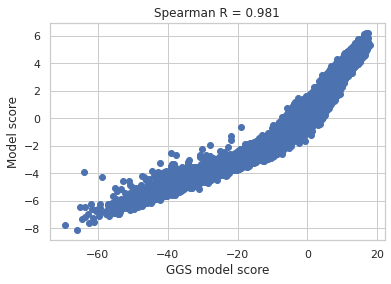

In [79]:
plt.scatter(df['ml_score'].values, df.old_ml_score)
plt.xlabel('GGS model score'); 
plt.ylabel('Model score');
from scipy.stats import spearmanr
rho = spearmanr(df['ml_score'].values, df.old_ml_score)[0]
plt.title(f"Spearman R = {rho:.3f}")

In [87]:
n_steps = optimizer_params['num_iter']*optimizer_params['seqs_per_iter']
n_mut = optimizer_params['num_mutations']
fn = f"nucb_ggs_results_num_mutations_{n_mut}_nsteps_{n_steps}.csv"
optimizer.save_results(filename=fn, n_seqs_to_keep=30000)

#### K=5

In [90]:
NUM_MUT = 5
NUM_ITER = 200
THRESHOLD = 9

model_path = '../NucB/trained_models/nucb_GGS_model_final_model_epoch_43_val_loss_0.8608.pt'

new_task_weights = {
    'activity_greater_than_neg_control': 0.000,
    'activity_greater_than_wt': 1.000,
    'activity_greater_than_a73r': 0.000
}

optimizer_params = {
    'new_task_weights': new_task_weights,
    'normalize_scores': True,
    'score_threshold': THRESHOLD, 
    'reversal_threshold': 0.0,
    #'ref_score_value': 0.0, 
    #'ref_score_scale': 0.0, 
    'seqs_per_iter': 520, 
    'num_iter':NUM_ITER, 
    'init_score_batch_size': 500, # only useful if score matrix is not specified, to compute single mutant scores
    'T': 1.5, # use 3 for not normalized scores
    'seed': 7,
    'gamma': 1.0, # typically 1.0
    'cooling_rate': 0.9 , # for slower simple cooling. Use 0.9 for a fast one
    'num_mutations': NUM_MUT,
    'sites_to_ignore': [1] # known bad sites that we should not sample sequences from
}

'''
# Load from the pickle file
with open('single_mutant_scores_amylase.pkl', 'rb') as file:
   initial_score_matrix = pickle.load(file)
'''

import seq2fitness_protein_optimizer as protein_optimizer
importlib.reload(protein_optimizer)
optimizer = protein_optimizer.ProteinOptimizer(optimizer_params, 
                                               model_checkpoint_path=model_path, 
                                               model_params=None, 
                                               esm_only=False,
                                               score_matrix=None,
                                               simple_simulated_annealing=False, 
                                               cool_then_heat = False)
initial_score_matrix = optimizer.initial_score_matrix
print(f"phase transition threshold is {optimizer.score_threshold}")




# Run optimizer
start_time = time.time()
df, df_stats = optimizer.optimize()
end_time = time.time()
# Print the elapsed time

Our main device will be cuda:0
Total number of trainable parameters in the model: 125487
Number of trainable parameters in the model excluding ESM: 125487
Total number of parameters in the model: 651168741
The reference sequence is MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASRYPETGAHISDAIKAGHADVCTIERSGADKRRQESLKGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGAGSWVGNRLNGYADGTRILFIVQ.
Our main device is still cuda:0
The reference sequence has score -6.57.
Computing initial score matrix, using batches of 500.
Scoring all single mutants to compute initial score matrix.
Computing scores for 2679 single mutants.
Finished sequence 0 of 2679.
Finished sequence 500 of 2679.
Finished sequence 1000 of 2679.
Finished sequence 1500 of 2679.
Finished sequence 2000 of 2679.
Finished sequence 2500 of 2679.
Reference score value: -7.9975, std dev: 7.4738. To normalize scores.
phase transition threshold is 9

Starting iter 0: processing 520 sequences, using T = 1.5.
Joint probability has 1.95e+03 effective entrie

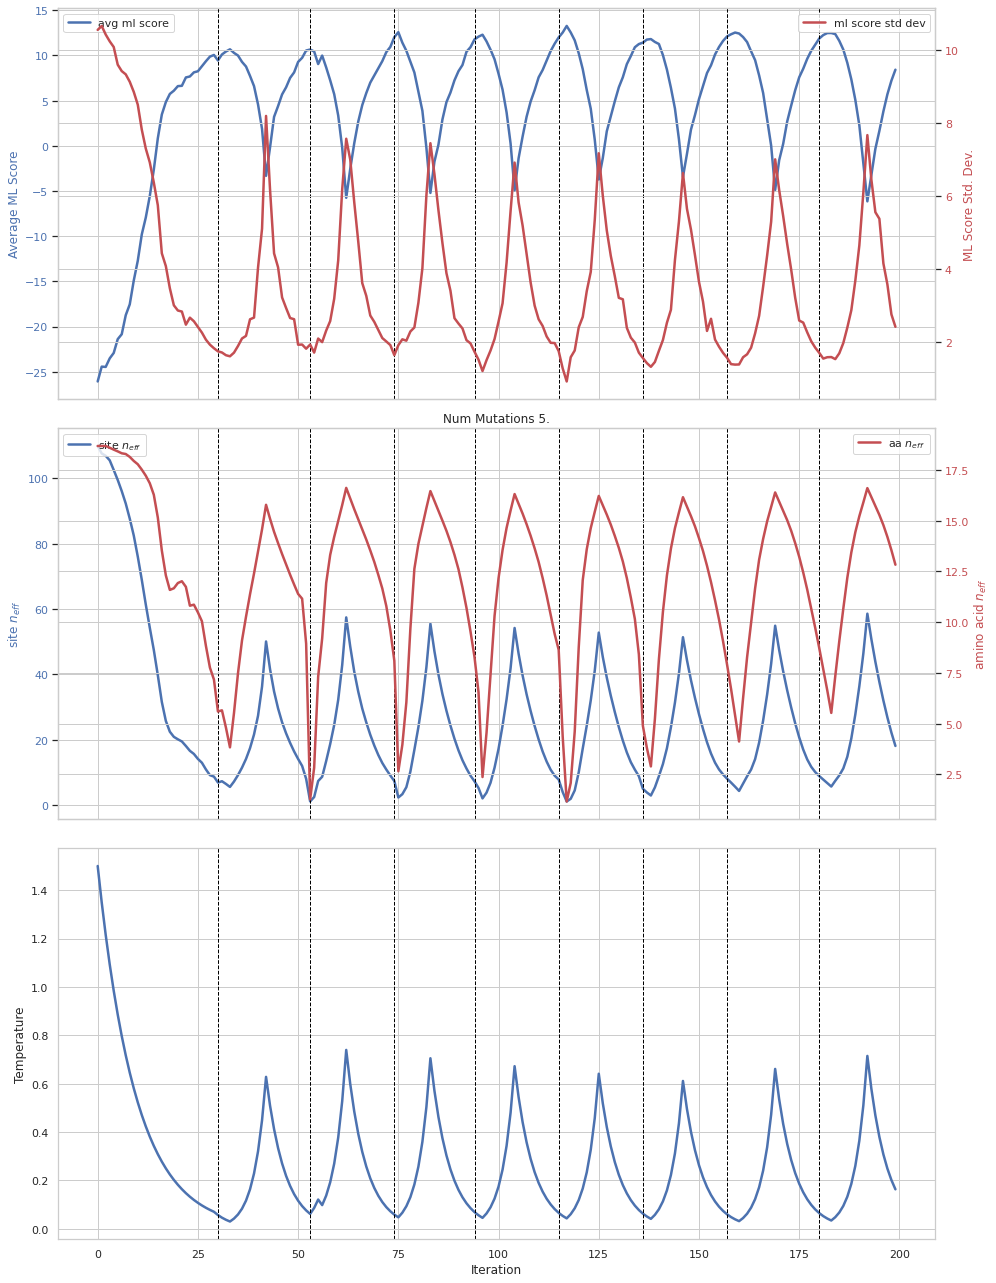

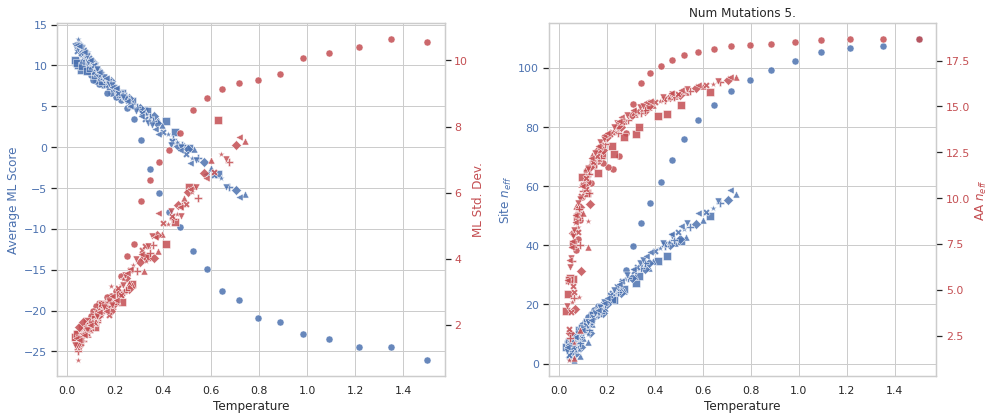

29
29


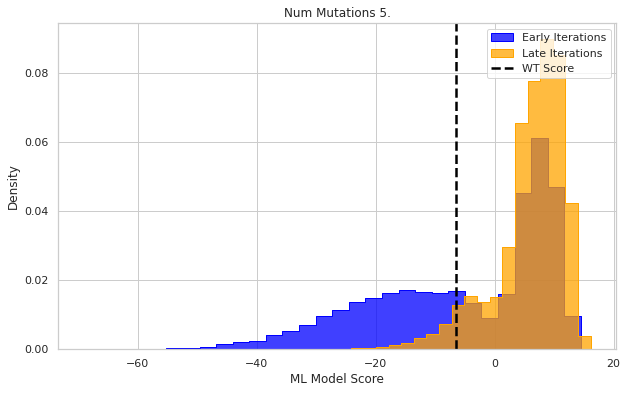

In [92]:
optimizer.plot_scores()

In [93]:
df['ml_score'] = score_sequences(df['sequences'])
df = df.sort_values('ml_score', ascending=False)
df.index = range(len(df))
df

Total number of trainable parameters in the model: 125487
Number of trainable parameters in the model excluding ESM: 125487
Total number of parameters in the model: 651168741
Finished sequence 0 of 92370.
Finished sequence 2000 of 92370.
Finished sequence 4000 of 92370.
Finished sequence 6000 of 92370.
Finished sequence 8000 of 92370.
Finished sequence 10000 of 92370.
Finished sequence 12000 of 92370.
Finished sequence 14000 of 92370.
Finished sequence 16000 of 92370.
Finished sequence 18000 of 92370.
Finished sequence 20000 of 92370.
Finished sequence 22000 of 92370.
Finished sequence 24000 of 92370.
Finished sequence 26000 of 92370.
Finished sequence 28000 of 92370.
Finished sequence 30000 of 92370.
Finished sequence 32000 of 92370.
Finished sequence 34000 of 92370.
Finished sequence 36000 of 92370.
Finished sequence 38000 of 92370.
Finished sequence 40000 of 92370.
Finished sequence 42000 of 92370.
Finished sequence 44000 of 92370.
Finished sequence 46000 of 92370.
Finished sequence

,sequences,ml_score,counts,num_mutations,iteration
0,W5K-S20W-A23W-A24W-G32A,5.602705,1,5,93
1,A13M-S20W-A23W-A24W-G32A,5.571415,1,5,139
2,A6C-S20W-A23W-A24W-G32A,5.565784,1,5,74
3,S20W-A23W-A24L-G32A-A63S,5.501807,1,5,156
4,A6W-S20W-A23W-A24G-G32A,5.411157,1,5,78
...,...,...,...,...,...
92365,K4N-L10D-F11N-L16S-W123M,-6.812830,1,5,3
92366,L17V-L40G-G61Y-V65E-M99R,-6.822100,1,5,1
92367,I54C-R77N-S113W-G119A-S122R,-7.075078,1,5,0
92368,F42S-Y47P-D64P-L81H-V141W,-7.812861,1,5,2


In [94]:
n_steps = optimizer_params['num_iter']*optimizer_params['seqs_per_iter']
n_mut = optimizer_params['num_mutations']
fn = f"nucb_ggs_results_num_mutations_{n_mut}_nsteps_{n_steps}.csv"
optimizer.save_results(filename=fn, n_seqs_to_keep=30000)

#### K = 4

In [97]:
NUM_MUT = 4
NUM_ITER = 200
THRESHOLD = 8

model_path = '../NucB/trained_models/nucb_GGS_model_final_model_epoch_43_val_loss_0.8608.pt'

new_task_weights = {
    'activity_greater_than_neg_control': 0.000,
    'activity_greater_than_wt': 1.000,
    'activity_greater_than_a73r': 0.000
}

optimizer_params = {
    'new_task_weights': new_task_weights,
    'normalize_scores': True,
    'score_threshold': THRESHOLD, 
    'reversal_threshold': 0.0,
    #'ref_score_value': 0.0, 
    #'ref_score_scale': 0.0, 
    'seqs_per_iter': 520, 
    'num_iter':NUM_ITER, 
    'init_score_batch_size': 500, # only useful if score matrix is not specified, to compute single mutant scores
    'T': 1.5, # use 3 for not normalized scores
    'seed': 7,
    'gamma': 1.0, # typically 1.0
    'cooling_rate': 0.9 , # for slower simple cooling. Use 0.9 for a fast one
    'num_mutations': NUM_MUT,
    'sites_to_ignore': [1] # known bad sites that we should not sample sequences from
}

'''
# Load from the pickle file
with open('single_mutant_scores_amylase.pkl', 'rb') as file:
   initial_score_matrix = pickle.load(file)
'''

import seq2fitness_protein_optimizer as protein_optimizer
importlib.reload(protein_optimizer)
optimizer = protein_optimizer.ProteinOptimizer(optimizer_params, 
                                               model_checkpoint_path=model_path, 
                                               model_params=None, 
                                               esm_only=False,
                                               score_matrix=None,
                                               simple_simulated_annealing=False, 
                                               cool_then_heat = False)
initial_score_matrix = optimizer.initial_score_matrix
print(f"phase transition threshold is {optimizer.score_threshold}")




# Run optimizer
start_time = time.time()
df, df_stats = optimizer.optimize()
end_time = time.time()
# Print the elapsed time

Our main device will be cuda:0
Total number of trainable parameters in the model: 125487
Number of trainable parameters in the model excluding ESM: 125487
Total number of parameters in the model: 651168741
The reference sequence is MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASRYPETGAHISDAIKAGHADVCTIERSGADKRRQESLKGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGAGSWVGNRLNGYADGTRILFIVQ.
Our main device is still cuda:0
The reference sequence has score -6.57.
Computing initial score matrix, using batches of 500.
Scoring all single mutants to compute initial score matrix.
Computing scores for 2679 single mutants.
Finished sequence 0 of 2679.
Finished sequence 500 of 2679.
Finished sequence 1000 of 2679.
Finished sequence 1500 of 2679.
Finished sequence 2000 of 2679.
Finished sequence 2500 of 2679.
Reference score value: -7.9975, std dev: 7.4738. To normalize scores.
phase transition threshold is 8

Starting iter 0: processing 520 sequences, using T = 1.5.
Joint probability has 1.95e+03 effective entrie

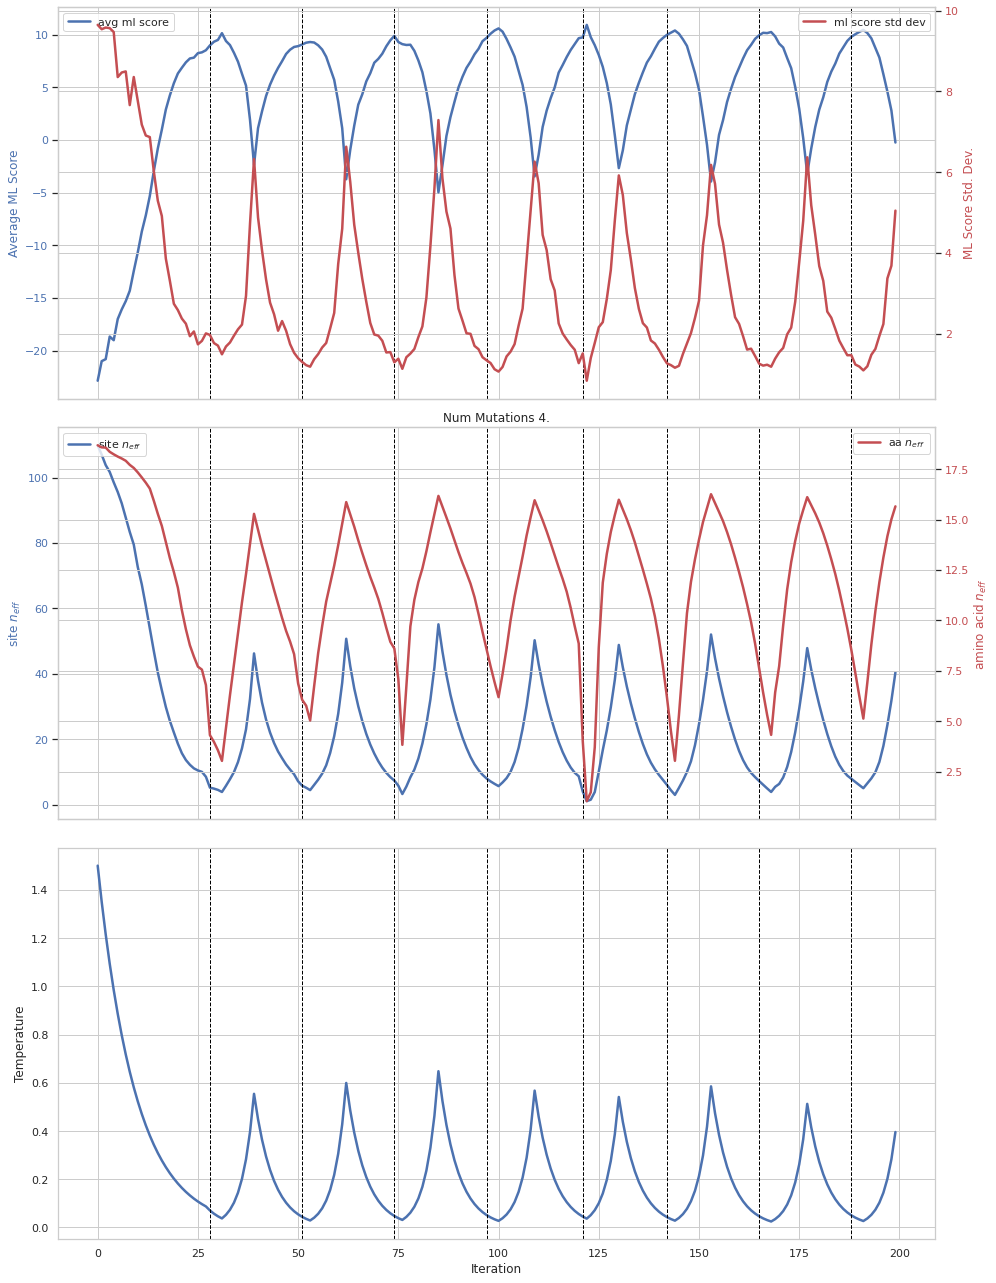

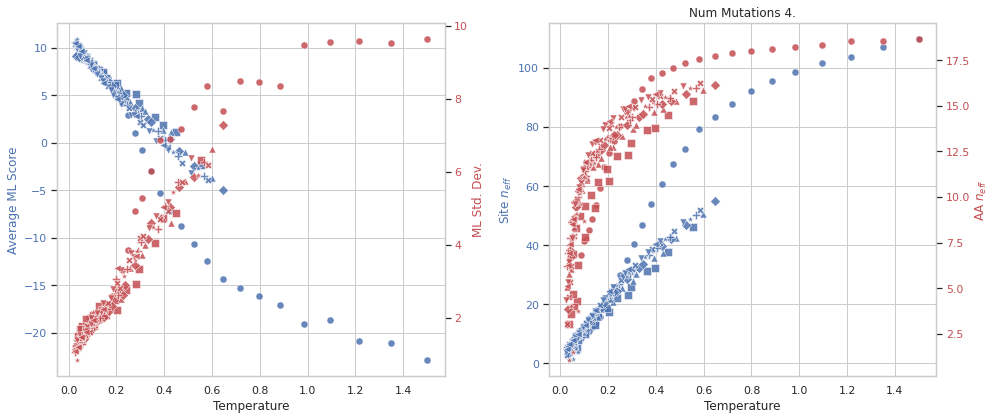

27
27


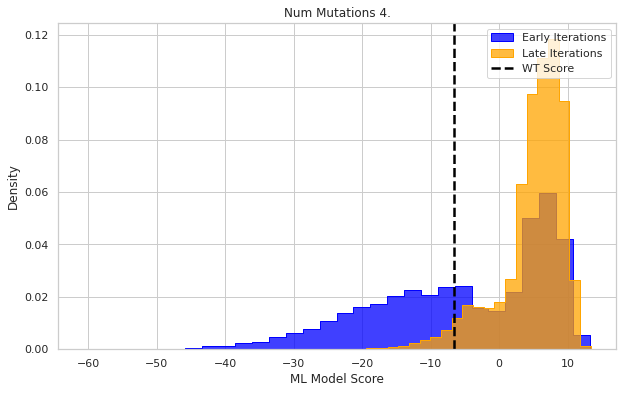

In [98]:
optimizer.plot_scores()

In [99]:
# Rescore sequences
df['ml_score'] = score_sequences(df['sequences'])
df = df.sort_values('ml_score', ascending=False)
df.index = range(len(df))


# Save  sequences
n_steps = optimizer_params['num_iter']*optimizer_params['seqs_per_iter']
n_mut = optimizer_params['num_mutations']
fn = f"nucb_ggs_results_num_mutations_{n_mut}_nsteps_{n_steps}.csv"
optimizer.save_results(filename=fn, n_seqs_to_keep=30000)

df

Total number of trainable parameters in the model: 125487
Number of trainable parameters in the model excluding ESM: 125487
Total number of parameters in the model: 651168741
Finished sequence 0 of 81952.
Finished sequence 2000 of 81952.
Finished sequence 4000 of 81952.
Finished sequence 6000 of 81952.
Finished sequence 8000 of 81952.
Finished sequence 10000 of 81952.
Finished sequence 12000 of 81952.
Finished sequence 14000 of 81952.
Finished sequence 16000 of 81952.
Finished sequence 18000 of 81952.
Finished sequence 20000 of 81952.
Finished sequence 22000 of 81952.
Finished sequence 24000 of 81952.
Finished sequence 26000 of 81952.
Finished sequence 28000 of 81952.
Finished sequence 30000 of 81952.
Finished sequence 32000 of 81952.
Finished sequence 34000 of 81952.
Finished sequence 36000 of 81952.
Finished sequence 38000 of 81952.
Finished sequence 40000 of 81952.
Finished sequence 42000 of 81952.
Finished sequence 44000 of 81952.
Finished sequence 46000 of 81952.
Finished sequence

,sequences,ml_score,counts,num_mutations,iteration
0,A6M-S20W-A23W-G32A,4.952772,5,4,24
1,S20W-A23W-G32A-A63S,4.938106,13,4,73
2,A6C-S20W-A23W-G32A,4.886049,9,4,70
3,V15M-S20W-A23W-G32A,4.865616,2,4,25
4,S20W-A23W-A24L-G32A,4.855655,23,4,19
...,...,...,...,...,...
81947,G51S-W95Q-G119V-V141S,-5.836246,1,4,3
81948,V15W-D37C-P48H-V124G,-5.881246,1,4,0
81949,Q28L-E94C-C100R-R110S,-6.031620,1,4,0
81950,A57E-Q78K-D91I-F139R,-6.169718,1,4,2


#### K = 3

In [103]:
NUM_MUT = 3
NUM_ITER = 200
THRESHOLD = 7

model_path = '../NucB/trained_models/nucb_GGS_model_final_model_epoch_43_val_loss_0.8608.pt'

new_task_weights = {
    'activity_greater_than_neg_control': 0.000,
    'activity_greater_than_wt': 1.000,
    'activity_greater_than_a73r': 0.000
}

optimizer_params = {
    'new_task_weights': new_task_weights,
    'normalize_scores': True,
    'score_threshold': THRESHOLD, 
    'reversal_threshold': 0.0,
    #'ref_score_value': 0.0, 
    #'ref_score_scale': 0.0, 
    'seqs_per_iter': 520, 
    'num_iter':NUM_ITER, 
    'init_score_batch_size': 500, # only useful if score matrix is not specified, to compute single mutant scores
    'T': 1.5, # use 3 for not normalized scores
    'seed': 7,
    'gamma': 1.0, # typically 1.0
    'cooling_rate': 0.9 , # for slower simple cooling. Use 0.9 for a fast one
    'num_mutations': NUM_MUT,
    'sites_to_ignore': [1] # known bad sites that we should not sample sequences from
}

'''
# Load from the pickle file
with open('single_mutant_scores_amylase.pkl', 'rb') as file:
   initial_score_matrix = pickle.load(file)
'''

import seq2fitness_protein_optimizer as protein_optimizer
importlib.reload(protein_optimizer)
optimizer = protein_optimizer.ProteinOptimizer(optimizer_params, 
                                               model_checkpoint_path=model_path, 
                                               model_params=None, 
                                               esm_only=False,
                                               score_matrix=None,
                                               simple_simulated_annealing=False, 
                                               cool_then_heat = False)
initial_score_matrix = optimizer.initial_score_matrix
print(f"phase transition threshold is {optimizer.score_threshold}")




# Run optimizer
start_time = time.time()
df, df_stats = optimizer.optimize()
end_time = time.time()
# Print the elapsed time

Our main device will be cuda:0
Total number of trainable parameters in the model: 125487
Number of trainable parameters in the model excluding ESM: 125487
Total number of parameters in the model: 651168741
The reference sequence is MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASRYPETGAHISDAIKAGHADVCTIERSGADKRRQESLKGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGAGSWVGNRLNGYADGTRILFIVQ.
Our main device is still cuda:0
The reference sequence has score -6.57.
Computing initial score matrix, using batches of 500.
Scoring all single mutants to compute initial score matrix.
Computing scores for 2679 single mutants.
Finished sequence 0 of 2679.
Finished sequence 500 of 2679.
Finished sequence 1000 of 2679.
Finished sequence 1500 of 2679.
Finished sequence 2000 of 2679.
Finished sequence 2500 of 2679.
Reference score value: -7.9975, std dev: 7.4738. To normalize scores.
phase transition threshold is 7

Starting iter 0: processing 520 sequences, using T = 1.5.
Joint probability has 1.95e+03 effective entrie

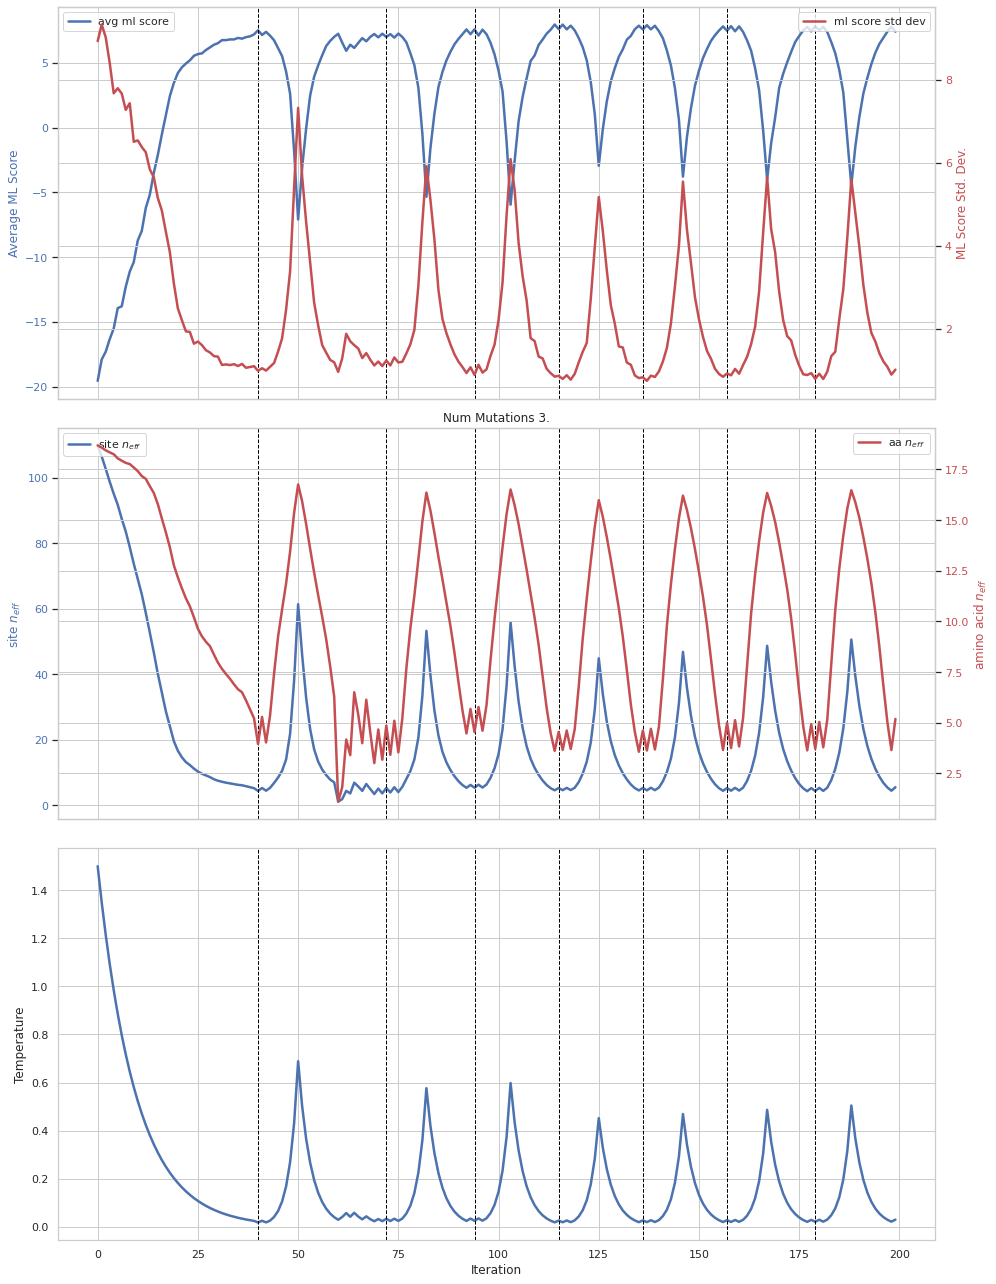

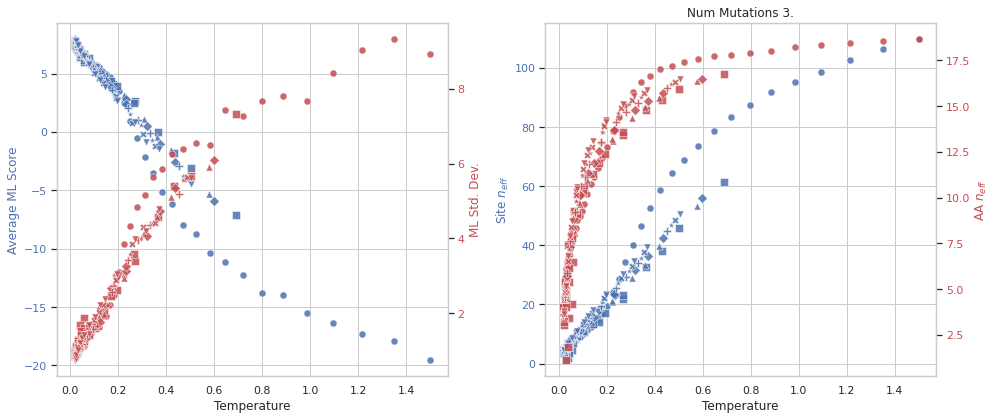

39
39


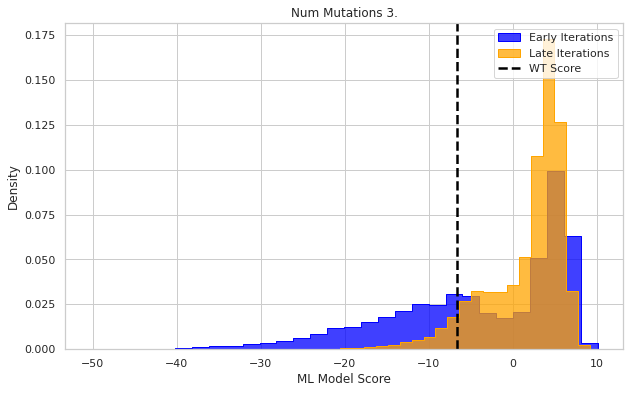

In [105]:
optimizer.plot_scores()

In [106]:
# Rescore sequences
df['ml_score'] = score_sequences(df['sequences'])
df = df.sort_values('ml_score', ascending=False)
df.index = range(len(df))


# Save  sequences
n_steps = optimizer_params['num_iter']*optimizer_params['seqs_per_iter']
n_mut = optimizer_params['num_mutations']
fn = f"nucb_ggs_results_num_mutations_{n_mut}_nsteps_{n_steps}.csv"
optimizer.save_results(filename=fn, n_seqs_to_keep=30000)

df

Total number of trainable parameters in the model: 125487
Number of trainable parameters in the model excluding ESM: 125487
Total number of parameters in the model: 651168741
Finished sequence 0 of 49935.
Finished sequence 2000 of 49935.
Finished sequence 4000 of 49935.
Finished sequence 6000 of 49935.
Finished sequence 8000 of 49935.
Finished sequence 10000 of 49935.
Finished sequence 12000 of 49935.
Finished sequence 14000 of 49935.
Finished sequence 16000 of 49935.
Finished sequence 18000 of 49935.
Finished sequence 20000 of 49935.
Finished sequence 22000 of 49935.
Finished sequence 24000 of 49935.
Finished sequence 26000 of 49935.
Finished sequence 28000 of 49935.
Finished sequence 30000 of 49935.
Finished sequence 32000 of 49935.
Finished sequence 34000 of 49935.
Finished sequence 36000 of 49935.
Finished sequence 38000 of 49935.
Finished sequence 40000 of 49935.
Finished sequence 42000 of 49935.
Finished sequence 44000 of 49935.
Finished sequence 46000 of 49935.
Finished sequence

,sequences,ml_score,counts,num_mutations,iteration
0,S20W-A23W-G32A,4.321710,101,3,25
1,A23W-A24W-G32A,4.180337,86,3,26
2,A6W-A23W-G32A,4.073156,94,3,20
3,S20M-A23W-G32A,4.007421,13,3,32
4,S20W-A23W-Y25F,3.933606,54,3,30
...,...,...,...,...,...
49930,C100K-V109E-Y131L,-5.501596,1,3,0
49931,D37L-P96Y-M97K,-5.621166,1,3,3
49932,A73D-D93T-G134I,-5.682219,1,3,0
49933,G61C-M99K-G119Y,-5.916113,1,3,3


#### K = 2

In [121]:
NUM_MUT = 2
NUM_ITER = 200
THRESHOLD = 2.5

model_path = '../NucB/trained_models/nucb_GGS_model_final_model_epoch_43_val_loss_0.8608.pt'

new_task_weights = {
    'activity_greater_than_neg_control': 0.000,
    'activity_greater_than_wt': 1.000,
    'activity_greater_than_a73r': 0.000
}

optimizer_params = {
    'new_task_weights': new_task_weights,
    'normalize_scores': True,
    'score_threshold': THRESHOLD, 
    'reversal_threshold': 0.0,
    #'ref_score_value': 0.0, 
    #'ref_score_scale': 0.0, 
    'seqs_per_iter': 520, 
    'num_iter':NUM_ITER, 
    'init_score_batch_size': 500, # only useful if score matrix is not specified, to compute single mutant scores
    'T': 1.5, # use 3 for not normalized scores
    'seed': 7,
    'gamma': 1.0, # typically 1.0
    'cooling_rate': 0.9 , # for slower simple cooling. Use 0.9 for a fast one
    'num_mutations': NUM_MUT,
    'sites_to_ignore': [1] # known bad sites that we should not sample sequences from
}

'''
# Load from the pickle file
with open('single_mutant_scores_amylase.pkl', 'rb') as file:
   initial_score_matrix = pickle.load(file)
'''

import seq2fitness_protein_optimizer as protein_optimizer
importlib.reload(protein_optimizer)
optimizer = protein_optimizer.ProteinOptimizer(optimizer_params, 
                                               model_checkpoint_path=model_path, 
                                               model_params=None, 
                                               esm_only=False,
                                               score_matrix=None,
                                               simple_simulated_annealing=False, 
                                               cool_then_heat = False)
initial_score_matrix = optimizer.initial_score_matrix
print(f"phase transition threshold is {optimizer.score_threshold}")




# Run optimizer
start_time = time.time()
df, df_stats = optimizer.optimize()
end_time = time.time()
# Print the elapsed time

Our main device will be cuda:0
Total number of trainable parameters in the model: 125487
Number of trainable parameters in the model excluding ESM: 125487
Total number of parameters in the model: 651168741
The reference sequence is MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASRYPETGAHISDAIKAGHADVCTIERSGADKRRQESLKGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGAGSWVGNRLNGYADGTRILFIVQ.
Our main device is still cuda:0
The reference sequence has score -6.57.
Computing initial score matrix, using batches of 500.
Scoring all single mutants to compute initial score matrix.
Computing scores for 2679 single mutants.
Finished sequence 0 of 2679.
Finished sequence 500 of 2679.
Finished sequence 1000 of 2679.
Finished sequence 1500 of 2679.
Finished sequence 2000 of 2679.
Finished sequence 2500 of 2679.
Reference score value: -7.9975, std dev: 7.4738. To normalize scores.
phase transition threshold is 2.5

Starting iter 0: processing 520 sequences, using T = 1.5.
Joint probability has 1.95e+03 effective entr

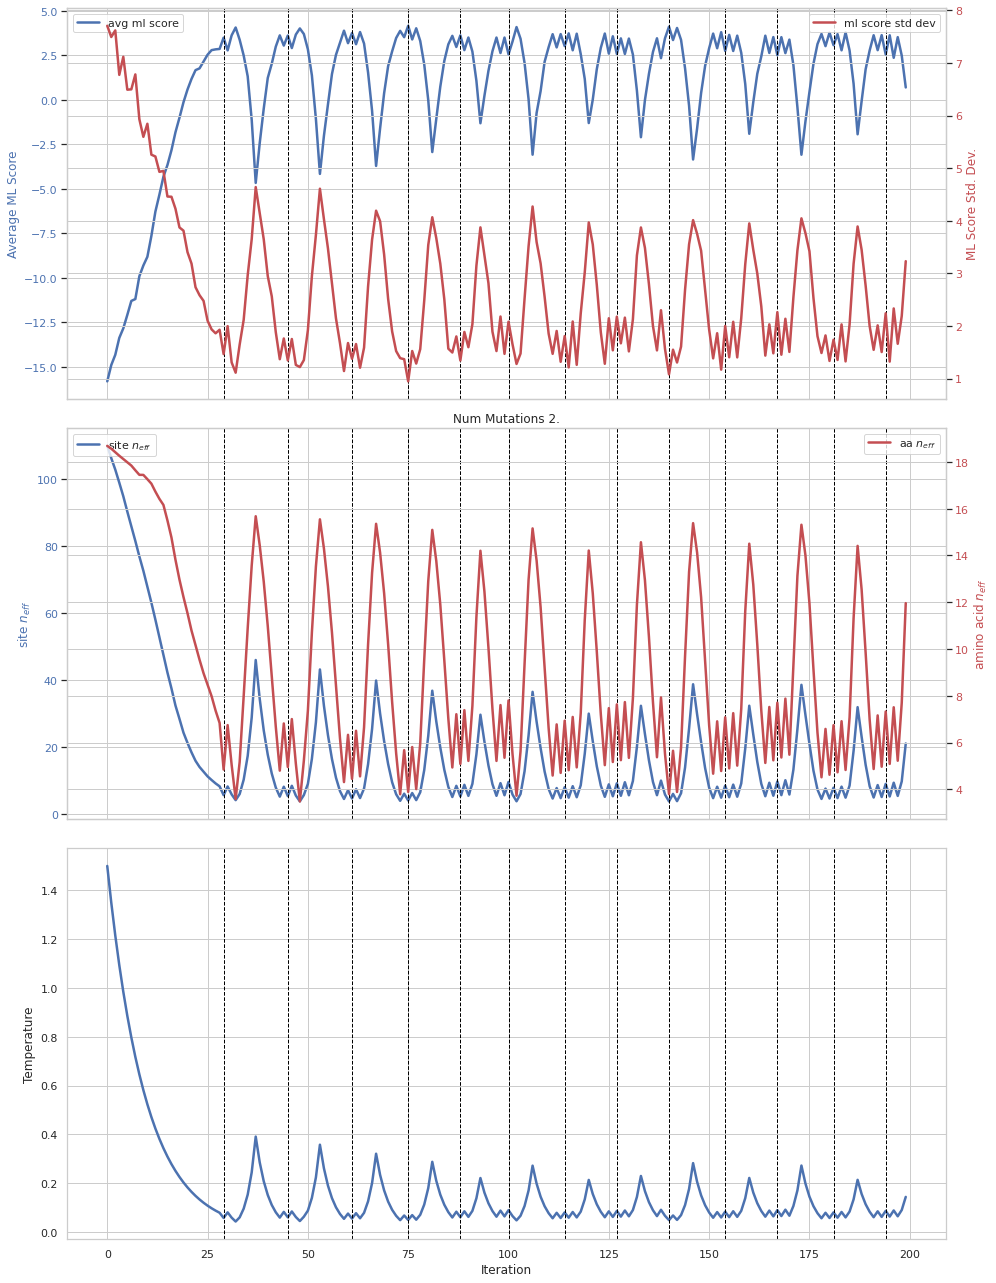

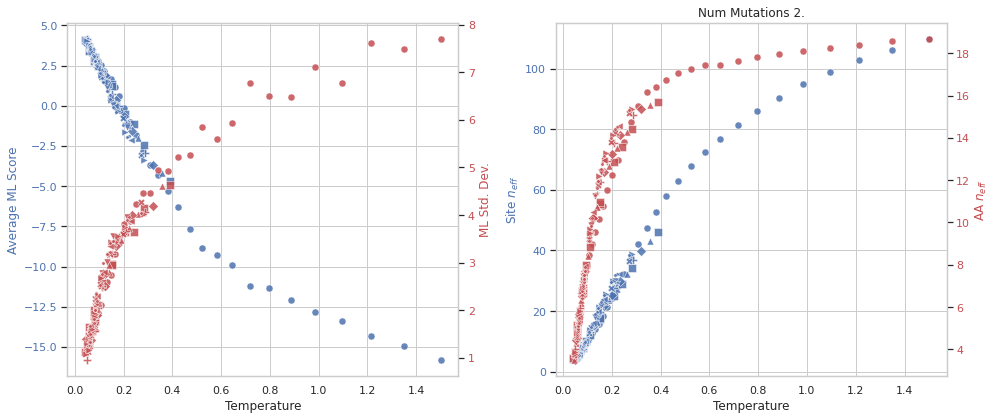

28
28


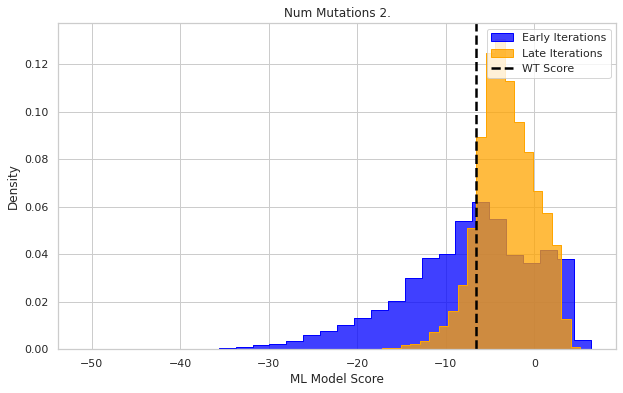

In [122]:
optimizer.plot_scores()

In [123]:
# Rescore sequences
df['ml_score'] = score_sequences(df['sequences'])
df = df.sort_values('ml_score', ascending=False)
df.index = range(len(df))


# Save  sequences
n_steps = optimizer_params['num_iter']*optimizer_params['seqs_per_iter']
n_mut = optimizer_params['num_mutations']
fn = f"nucb_ggs_results_num_mutations_{n_mut}_nsteps_{n_steps}.csv"
optimizer.save_results(filename=fn, n_seqs_to_keep=30000)

df

Total number of trainable parameters in the model: 125487
Number of trainable parameters in the model excluding ESM: 125487
Total number of parameters in the model: 651168741
Finished sequence 0 of 25888.
Finished sequence 2000 of 25888.
Finished sequence 4000 of 25888.
Finished sequence 6000 of 25888.
Finished sequence 8000 of 25888.
Finished sequence 10000 of 25888.
Finished sequence 12000 of 25888.
Finished sequence 14000 of 25888.
Finished sequence 16000 of 25888.
Finished sequence 18000 of 25888.
Finished sequence 20000 of 25888.
Finished sequence 22000 of 25888.
Finished sequence 24000 of 25888.


,sequences,ml_score,counts,num_mutations,iteration
0,A23W-G32A,3.251678,156,2,10
1,S20W-G32A,2.978890,137,2,19
2,S20W-A23W,2.953218,156,2,12
3,A23M-G32A,2.834532,139,2,15
4,A24W-G32A,2.814060,99,2,14
...,...,...,...,...,...
25883,C100K-V109E,-5.175830,1,2,0
25884,H53G-G104P,-5.197112,1,2,3
25885,I54E-I58G,-5.353761,1,2,4
25886,L40W-I137D,-5.608540,1,2,7


#### K=2to6

In [ ]:
NUM_MUT = 6
NUM_ITER = 200
THRESHOLD = 7

model_path = '../NucB/trained_models/nucb_GGS_model_final_model_epoch_43_val_loss_0.8608.pt'

new_task_weights = {
    'activity_greater_than_neg_control': 0.000,
    'activity_greater_than_wt': 1.000,
    'activity_greater_than_a73r': 0.000
}

optimizer_params = {
    'new_task_weights': new_task_weights,
    'normalize_scores': True,
    'score_threshold': THRESHOLD, 
    'reversal_threshold': 0.0,
    #'ref_score_value': 0.0, 
    #'ref_score_scale': 0.0, 
    'seqs_per_iter': 520, 
    'num_iter':NUM_ITER, 
    'init_score_batch_size': 500, # only useful if score matrix is not specified, to compute single mutant scores
    'T': 1.5, # use 3 for not normalized scores
    'seed': 7,
    'gamma': 1.0, # typically 1.0
    'cooling_rate': 0.9 , # for slower simple cooling. Use 0.9 for a fast one
    'num_mutations': NUM_MUT,
    'sites_to_ignore': [1], # known bad sites that we should not sample sequences from
    'sample_variety_of_mutation_numbers': True
}




import seq2fitness_protein_optimizer as protein_optimizer
importlib.reload(protein_optimizer)
optimizer = protein_optimizer.ProteinOptimizer(optimizer_params, 
                                               model_checkpoint_path=model_path, 
                                               model_params=None, 
                                               esm_only=False,
                                               score_matrix=None,
                                               simple_simulated_annealing=False, 
                                               cool_then_heat = False)
initial_score_matrix = optimizer.initial_score_matrix
print(f"phase transition threshold is {optimizer.score_threshold}")




# Run optimizer
start_time = time.time()
df, df_stats = optimizer.optimize()
end_time = time.time()
# Print the elapsed time

Our main device will be cuda:0
Total number of trainable parameters in the model: 125487
Number of trainable parameters in the model excluding ESM: 125487
Total number of parameters in the model: 651168741
The reference sequence is MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASRYPETGAHISDAIKAGHADVCTIERSGADKRRQESLKGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGAGSWVGNRLNGYADGTRILFIVQ.
Our main device is still cuda:0
The reference sequence has score -6.57.
Computing initial score matrix, using batches of 500.
Scoring all single mutants to compute initial score matrix.
Computing scores for 2679 single mutants.
Finished sequence 0 of 2679.
Finished sequence 500 of 2679.
Finished sequence 1000 of 2679.
Finished sequence 1500 of 2679.
Finished sequence 2000 of 2679.
Finished sequence 2500 of 2679.
Reference score value: -7.9975, std dev: 7.4738. To normalize scores.
phase transition threshold is 7

Starting iter 0: processing 520 sequences, using T = 1.5.
Joint probability has 1.95e+03 effective entrie

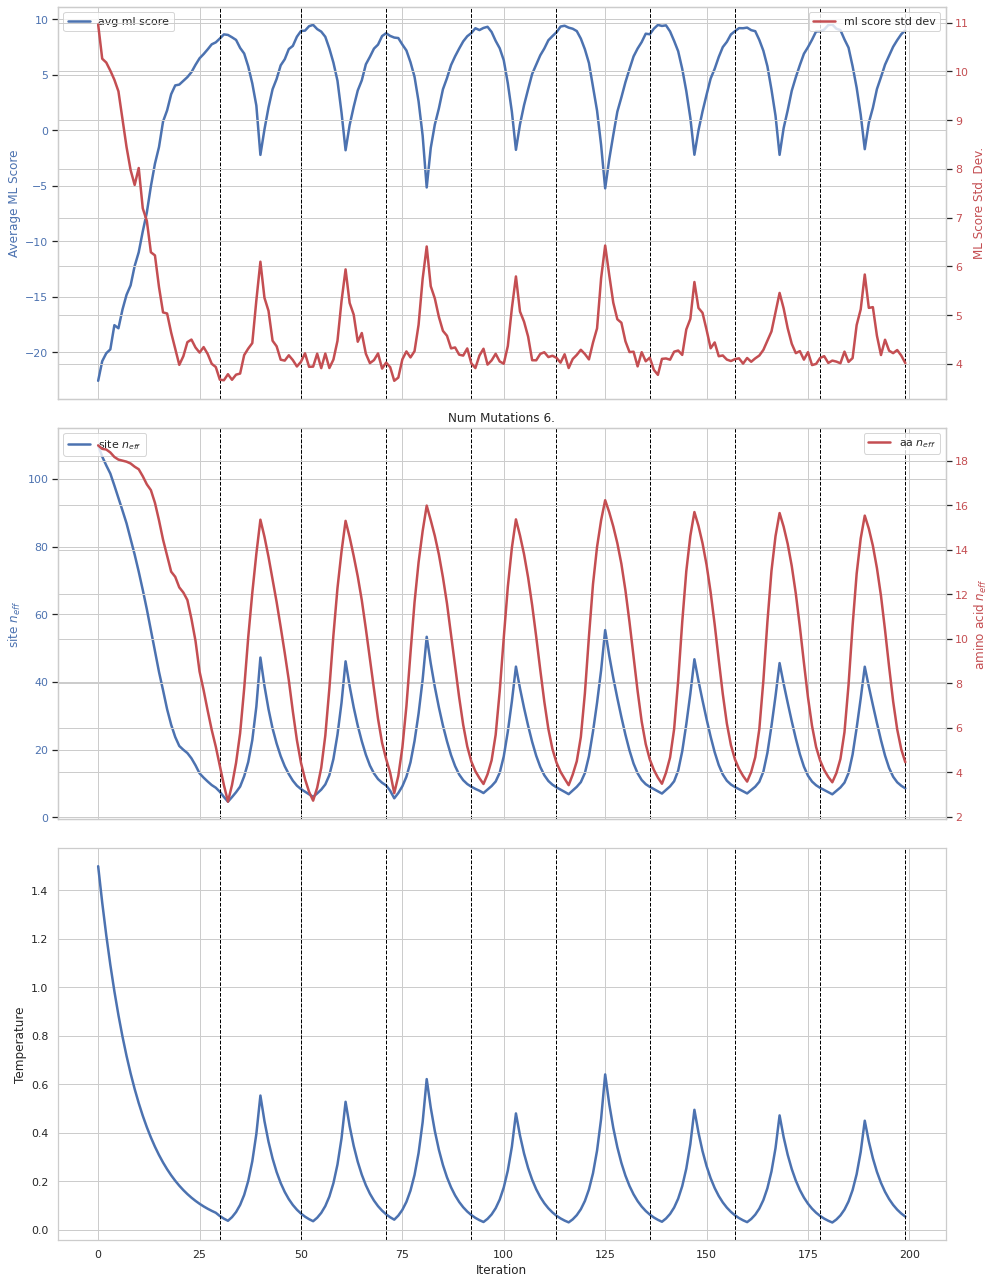

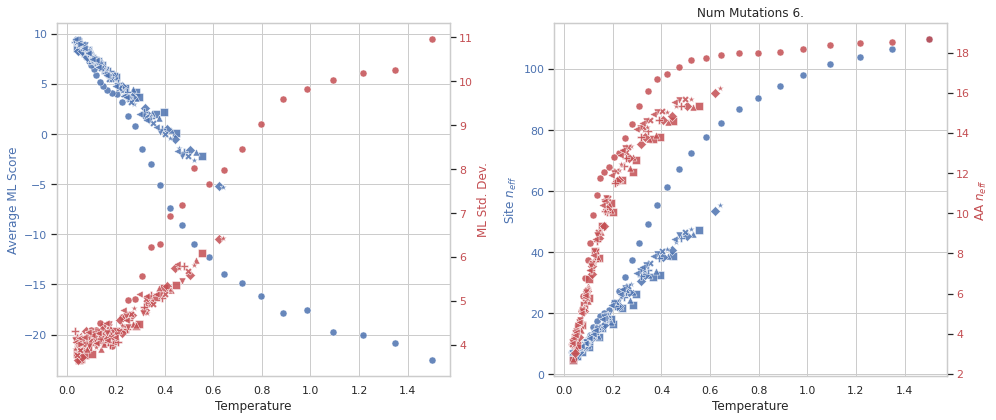

29
29


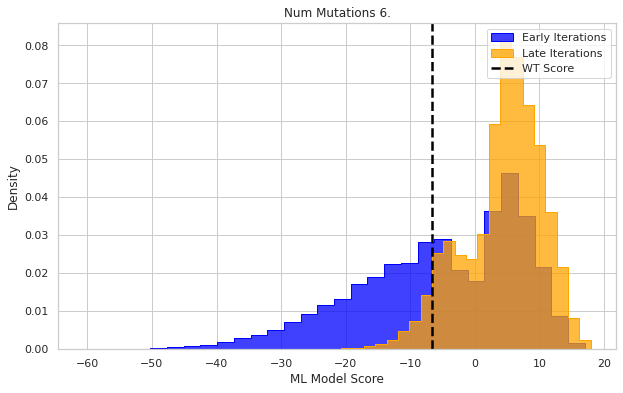

In [134]:
optimizer.plot_scores()

In [135]:
# Rescore sequences
df['ml_score'] = score_sequences(df['sequences'])
df = df.sort_values('ml_score', ascending=False)
df.index = range(len(df))


# Save  sequences
n_steps = optimizer_params['num_iter']*optimizer_params['seqs_per_iter']
n_mut = optimizer_params['num_mutations']
fn = f"nucb_ggs_results_num_mutations_2to6_nsteps_{n_steps}.csv"
optimizer.save_results(filename=fn, n_seqs_to_keep=30000)

df

Total number of trainable parameters in the model: 125487
Number of trainable parameters in the model excluding ESM: 125487
Total number of parameters in the model: 651168741
Finished sequence 0 of 60935.
Finished sequence 2000 of 60935.
Finished sequence 4000 of 60935.
Finished sequence 6000 of 60935.
Finished sequence 8000 of 60935.
Finished sequence 10000 of 60935.
Finished sequence 12000 of 60935.
Finished sequence 14000 of 60935.
Finished sequence 16000 of 60935.
Finished sequence 18000 of 60935.
Finished sequence 20000 of 60935.
Finished sequence 22000 of 60935.
Finished sequence 24000 of 60935.
Finished sequence 26000 of 60935.
Finished sequence 28000 of 60935.
Finished sequence 30000 of 60935.
Finished sequence 32000 of 60935.
Finished sequence 34000 of 60935.
Finished sequence 36000 of 60935.
Finished sequence 38000 of 60935.
Finished sequence 40000 of 60935.
Finished sequence 42000 of 60935.
Finished sequence 44000 of 60935.
Finished sequence 46000 of 60935.
Finished sequence

,sequences,ml_score,counts,num_mutations,iteration
0,A6W-S20W-A23W-A24L-G32A-A63S,5.881991,2,6,92
1,A6W-S20W-A23W-Y25F-G32A-A63S,5.835435,2,6,34
2,A13F-S20W-A23W-A24L-G32A-A63S,5.806690,2,6,92
3,S20W-A23W-A24F-Y25F-G32A-A63S,5.805027,5,6,49
4,A6W-A13F-S20W-A23W-G32A-A63S,5.791454,5,6,95
...,...,...,...,...,...
60930,L40H-S80T-G130W-D133V-G134E-Q142C,-6.625686,1,6,1
60931,L40G-F42V-I58Y-I84R-M97I-S122L,-6.660203,1,6,3
60932,L19N-I54F-C66K-A107H-G119V,-6.870296,1,6,2
60933,G61H-C66G-S80M-P96S-V109I-G121F,-6.980868,1,6,0
